Libraries:

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np
from utils.Viterbi import Viterbi
from utils.Plots import plotEPS_with_states, plotEPS_distribution
DATA_DIR="data/"
HIDDEN_STATES = 4

Data and parameters:

In [31]:
data = pd.read_csv(f"{DATA_DIR}hulls_every2_matchday2.csv")
data = data.dropna()
events=pd.read_csv(f"{DATA_DIR}matchday2_events.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]
shots_info=events[events["Type"]=="SHOT"]
home_shot=shots_info[shots_info["Team"]=="Home"]
away_shot=shots_info[shots_info["Team"]=="Away"]

sequence_XY = torch.tensor(data[["HomeHull","AwayHull"]].values/100)

posterior=torch.load(f"parameters/CopulaHMM_matchday2_{HIDDEN_STATES}states.pt")
initial_state_probs= posterior["probs_initial"]
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]

Run Viterbi algorithm:

In [32]:
MLS=Viterbi(observations=sequence_XY,
            initial_states_prob=initial_state_probs,
            transition_matrix=transition_matrix,
            shape_params1=shape_params1,
            rate_params1=rate_params1,
            shape_params2=shape_params2,
            rate_params2=rate_params2,
            theta=theta)
data["State"]=MLS.numpy()

## EPS over time (with states)

In [33]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue',
    #4: 'purple'
}

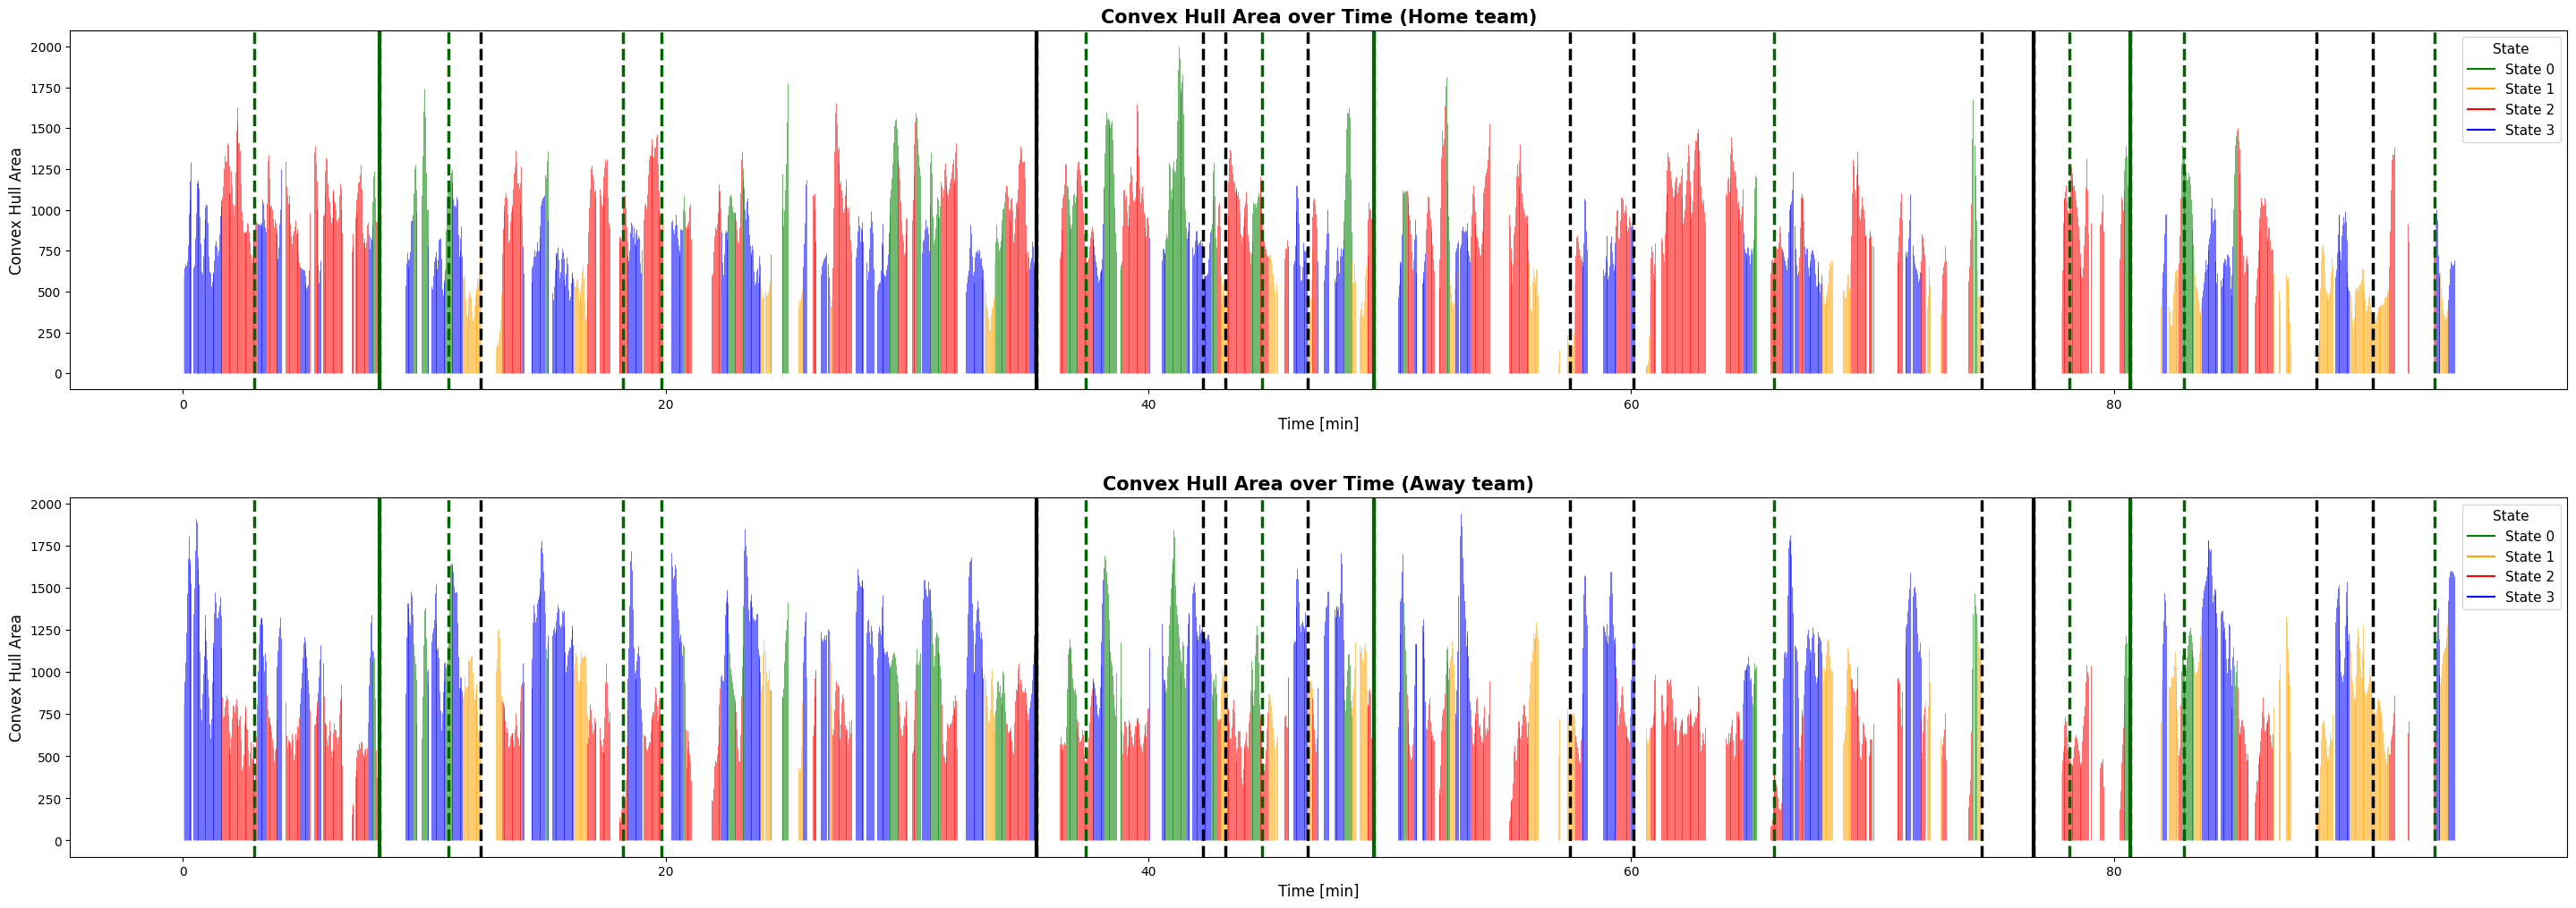

In [34]:
p=plotEPS_with_states(data,home_goals,away_goals,home_shot,away_shot,class_colors)
p

## EPS distribution by state

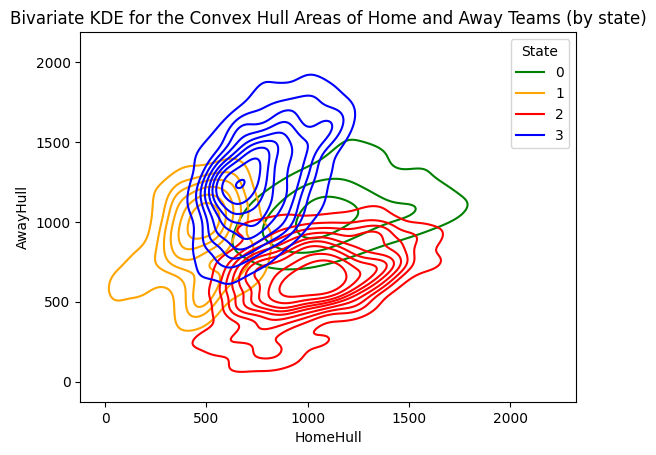

In [35]:
p=plotEPS_distribution(data,class_colors)
p